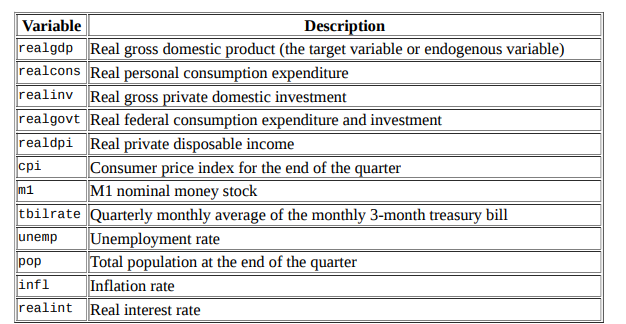

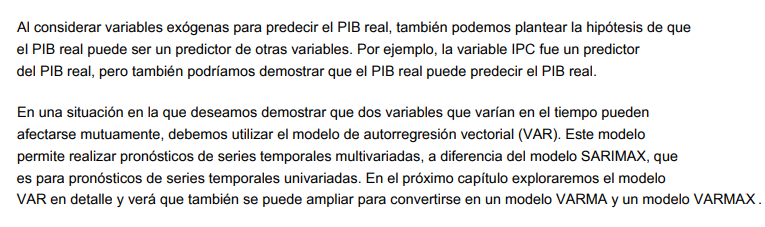

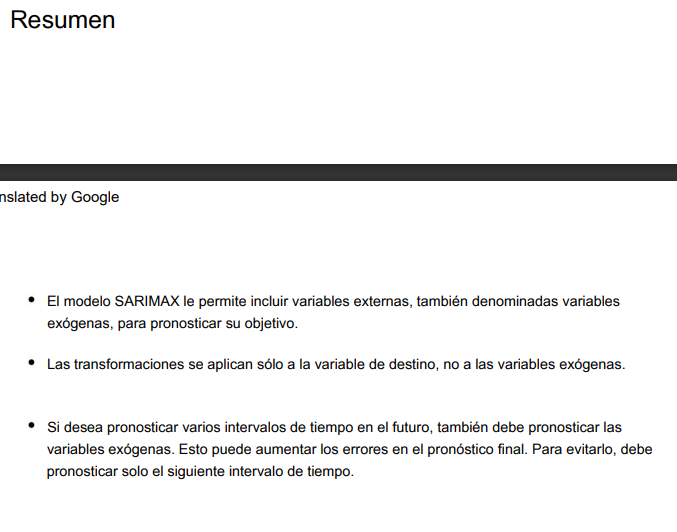

# NOTA Y RECORDATORIO

solo podemos predecir un paso de tiempo a la vez. y ademas en este modelo solo con una variable objetivo.

# Consigna de ejercicio:  PBI real. Inclusion de todas las variables exogenas en el modelo. 

### Biblioteca clave: statsmodels

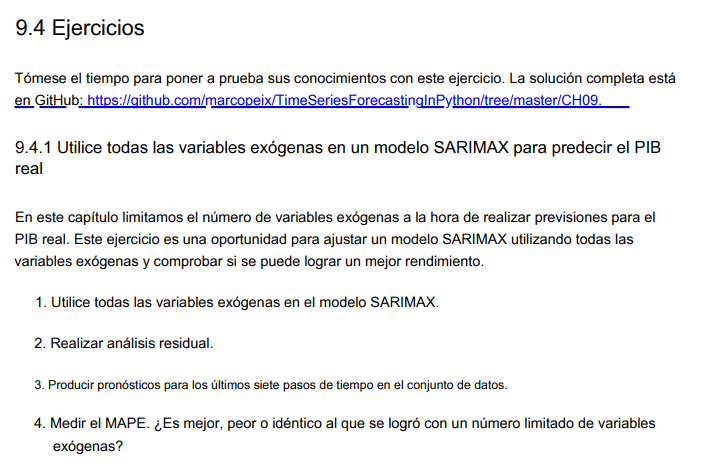

# LIBRERIAS

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data = macro_econ_data.set_index("year")
macro_econ_data

,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
year,,,,,,,,,,,,,
1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71


## 9.2 Forecasting the real GDP using the SARIMAX

In [3]:
target = macro_econ_data["realgdp"]
exog = [col for col in macro_econ_data.columns if col != "realgdp"]
exog

['quarter',
 'realcons',
 'realinv',
 'realgovt',
 'realdpi',
 'cpi',
 'm1',
 'tbilrate',
 'unemp',
 'pop',
 'infl',
 'realint']

In [4]:
ad_fuller_result = adfuller(target)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647173
p-value: 0.9982455372335032


This returns an ADF statistic of 1.75 and a p-value of 1.00. Since the ADF statistic is not
a large negative number, and the p-value is larger than 0.05, we cannot reject the null
hypothesis and conclude that the series is not stationary.
Therefore, we must apply a transformation and test for stationarity again. Here we will
difference the series once:

In [5]:
print("target.isnull().sum(): ", target.isnull().sum())
print("macro_econ_data[exog]: ", macro_econ_data[exog].isnull().sum())

target.isnull().sum():  0
macro_econ_data[exog]:  quarter     0
realcons    0
realinv     0
realgovt    0
realdpi     0
cpi         0
m1          0
tbilrate    0
unemp       0
pop         0
infl        0
realint     0
dtype: int64


In [6]:
target_diff = target.diff()
# Elimina valores NaN
target_diff = target_diff.dropna()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08
